# Axis to Regression Registration Pipeline

In [81]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure
import seaborn as sns
from scipy.stats import ttest_rel
# Fix for Dask DataFrame warning
from dask.config import set
set({"dataframe.query-planning": True})
from scaling_utils import compute_scaling_factor, scale_transform


## Data loading

### Load clinical data

In [2]:
# Change file paths to your own
file_path = 'C:/Users/molanre1/Desktop/WSIFIR/'
samples_file = file_path + 'NAT_samples_12.2024.csv'

#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv(samples_file)
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [97]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)


ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [103]:
#Initialize the row indexes for all the images

row_indexes = list(range(len(ids)))

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    axis_sampleid = selected_row['sampleid']
    reg_slideid = selected_row['reg_slideid']
    axis_slideid = selected_row['slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    axis_sampleid = int(axis_sampleid)

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'axis_sampleid': axis_sampleid,
        'reg_slideid': reg_slideid,
        'axis_slideid': axis_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')
    axis_image = io.load_astropath(sampleid=axis_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_2/{axis_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, axis_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

#Display the spatial data
sp

SpatialData object
├── Images
│     ├── 'sampleid_101_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_102_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_103_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_107_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_109_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), 

In [104]:
len(sp.images)

92

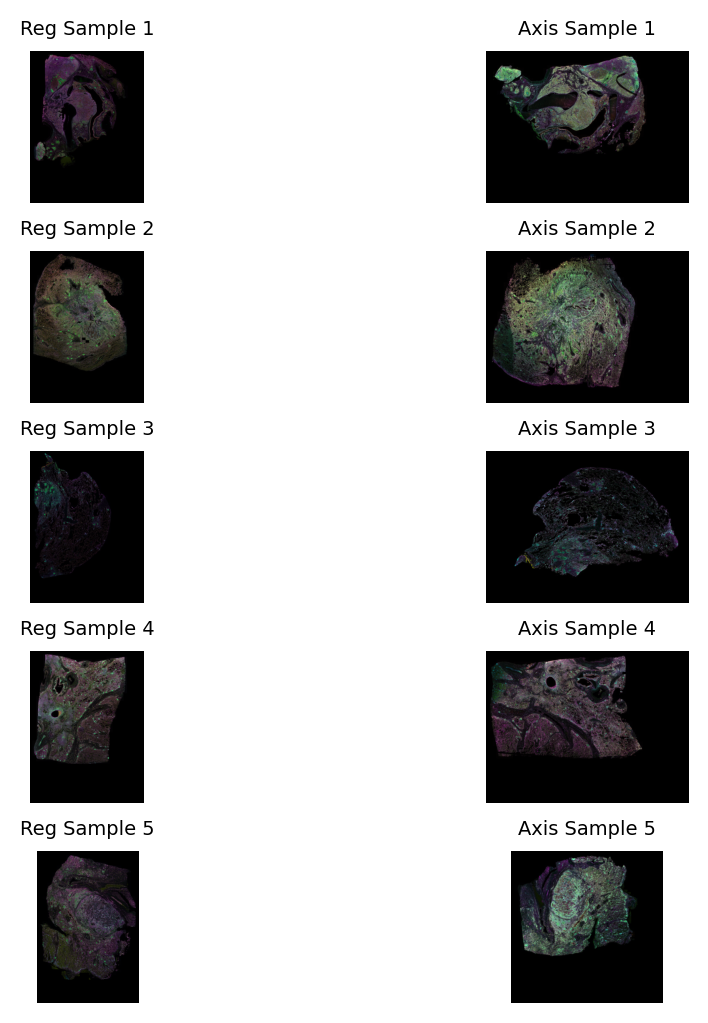

In [99]:
# Plot the first 5 images

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['axis_sampleid'], title="Axis Sample 1"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['axis_sampleid'], title="Axis Sample 2"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['axis_sampleid'], title="Axis Sample 3"),  # axis_sampleid
    
    pl.ShowImage(sdata=sp, sampleid=results[3]['reg_sampleid'], title="Reg Sample 4"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[3]['axis_sampleid'], title="Axis Sample 4"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[4]['reg_sampleid'], title="Reg Sample 5"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[4]['axis_sampleid'], title="Axis Sample 5"),  # axis_sampleid

   figsize=(5, 5),

)


## Rigid Registration (Scale 9)

### Load in spatial data 

In [ ]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]

# Convert all images to numpy arrays

cropped_images_arrays = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_arrays[sampleid] = cropped_image.compute()



In [108]:
# Convert all images to ants images
cropped_images_ants = {}
for sampleid, cropped_image in cropped_images_arrays.items():
    cropped_images_ants[sampleid] = ants.from_numpy(cropped_image)

cropped_images_ants

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_image': ANTsIma

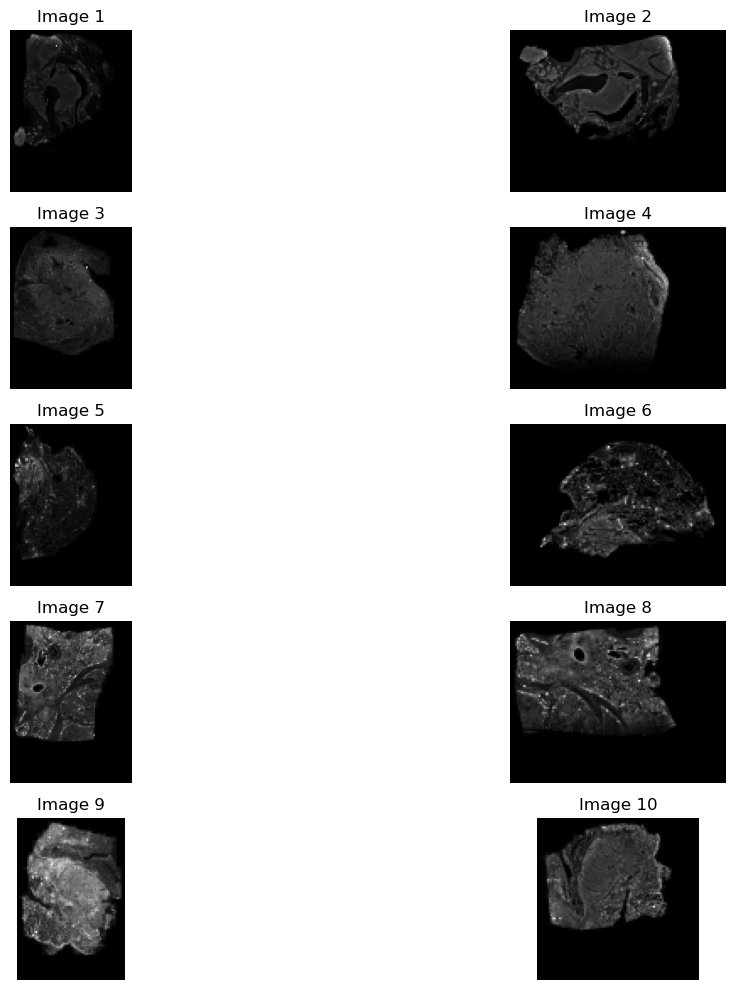

In [109]:
# Plot the first 10 images of cropped images using plt with 5 rows and 2 columns

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, cropped_image) in enumerate(cropped_images_ants.items()):
    if i < 10:
        axes[i].imshow(cropped_image.numpy(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()



### Pad images

In [110]:
# Create a function to pad all images in cropped_images_ants to the same size

def pad_images_to_same_size(images):
    # Get the maximum dimensions
    max_shape = np.max([img.shape for img in images.values()], axis=0)

    # Pad each image to the maximum dimensions
    padded_images = {}
    for sampleid, img in images.items():
        pad_width = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(max_shape)]
        padded_images[sampleid] = np.pad(img.numpy(), pad_width, mode='constant', constant_values=0)
    return padded_images
# Pad the images
padded_images = pad_images_to_same_size(cropped_images_ants)

# Convert the padded images to ANTs images
padded_images_ants = {}
for sampleid, padded_image in padded_images.items():
    padded_images_ants[sampleid] = ants.from_numpy(padded_image)

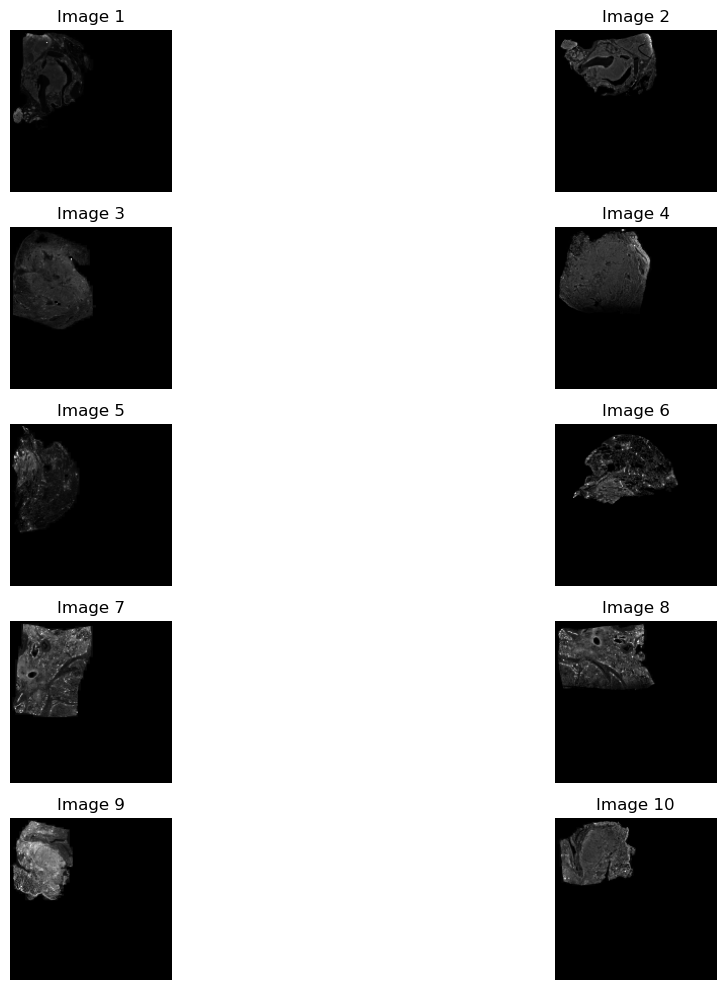

In [111]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [114]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images = []
axis_images = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i % 2 == 0:  # Even index
        regression_images.append((sampleid, padded_image))
    else:  # Odd index
        axis_images.append((sampleid, padded_image))

In [115]:
regression_images

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [116]:
axis_images

[('sampleid_101_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_107_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_535_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_112_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_114_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### ANTS Rigid transform 

In [142]:
#Register the regression images to the axis image

registered_images = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Perform registration
    registered_image = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Rigid',outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images[reg_sampleid] = registered_image['warpedmovout']

    #Apply the transformation to the moving image
    transformed_image = ants.apply_transforms(fixed=reg_image, moving=axis_image, transformlist=registered_image['fwdtransforms'])



antsRegistration -d 2 -r [0000029B1E98BE48,0000029B1E98BDA8,1] -m mattes[0000029B1E98BE48,0000029B1E98BDA8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,0000029B1E98BD08,0000029B1E98B368] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1E98B1A8,0000029B1E98B848,1] -m mattes[0000029B1E98B1A8,0000029B1E98B848,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000029B1E98B368,0000029B1E98BDA8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1E98B1A8,0000029B1E98B848,1] -m mattes[0000029B1E98B1A8,0000029B1E98B848,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Deskt

In [171]:
#Read the transformation matrices using ants.read_transform

transformation_matrices = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')

    # Store the transformation matrix
    transformation_matrices[reg_sampleid] = transformation_matrix

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters = {}
for sampleid, matrix in transformation_matrices.items():
    transformation_parameters[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

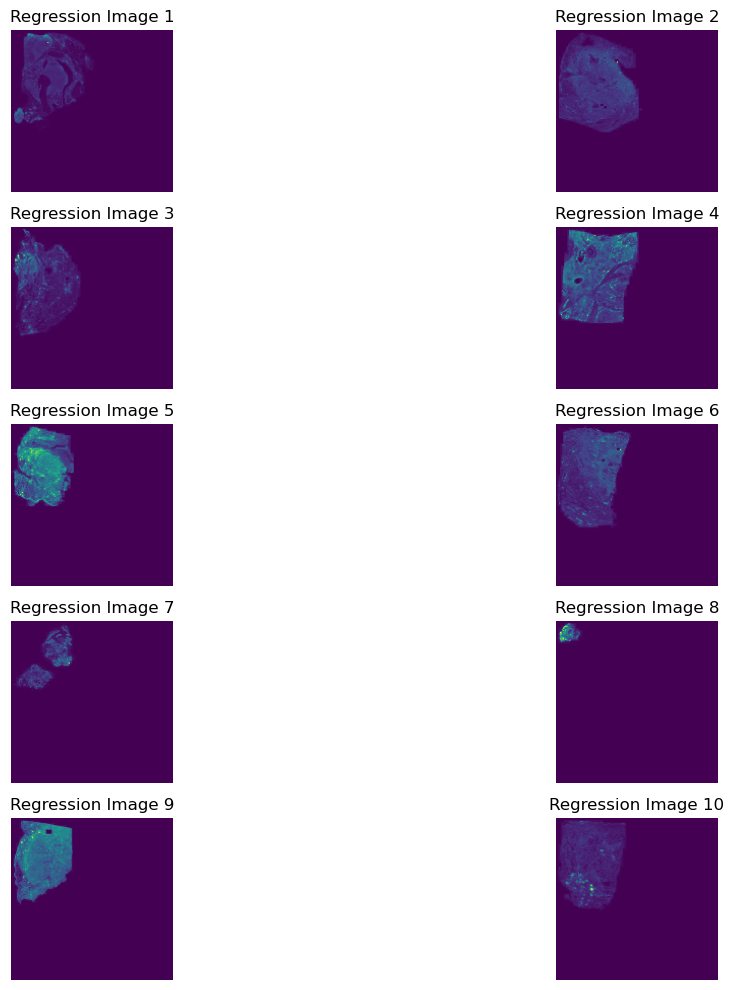

In [212]:
# Plot the first 10 regression images

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(regression_images):
    if i < 10:
        axes[i].imshow(padded_image.numpy())
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

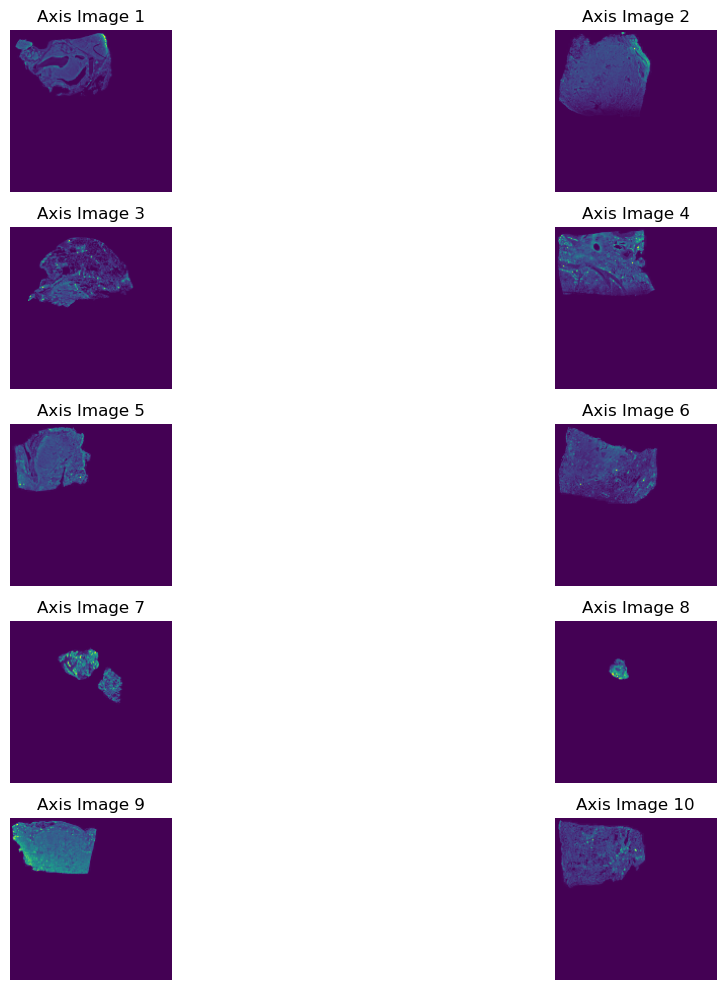

In [144]:
#Plot the first 10 axis images
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, axis_image) in enumerate(axis_images):
    if i < 10:
        axes[i].imshow(axis_image.numpy())
        axes[i].set_title(f'Axis Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()


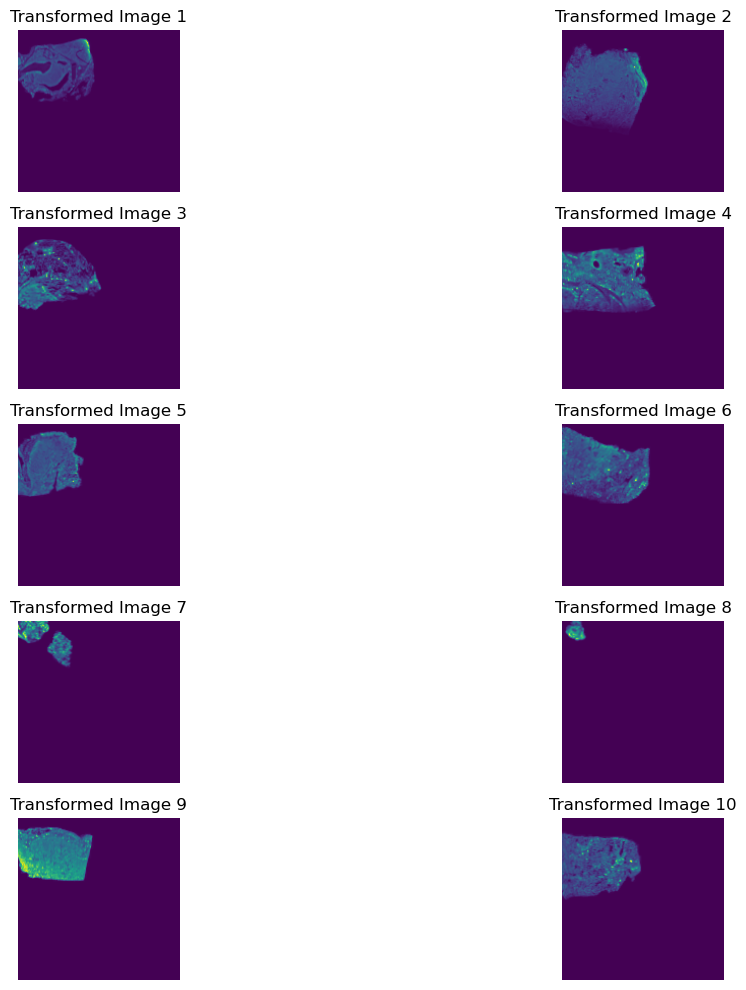

In [145]:
#Plot the first 10 registered images
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, transformed_image) in enumerate(registered_images.items()):
    if i < 10:
        axes[i].imshow(transformed_image.numpy())
        axes[i].set_title(f'Transformed Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()


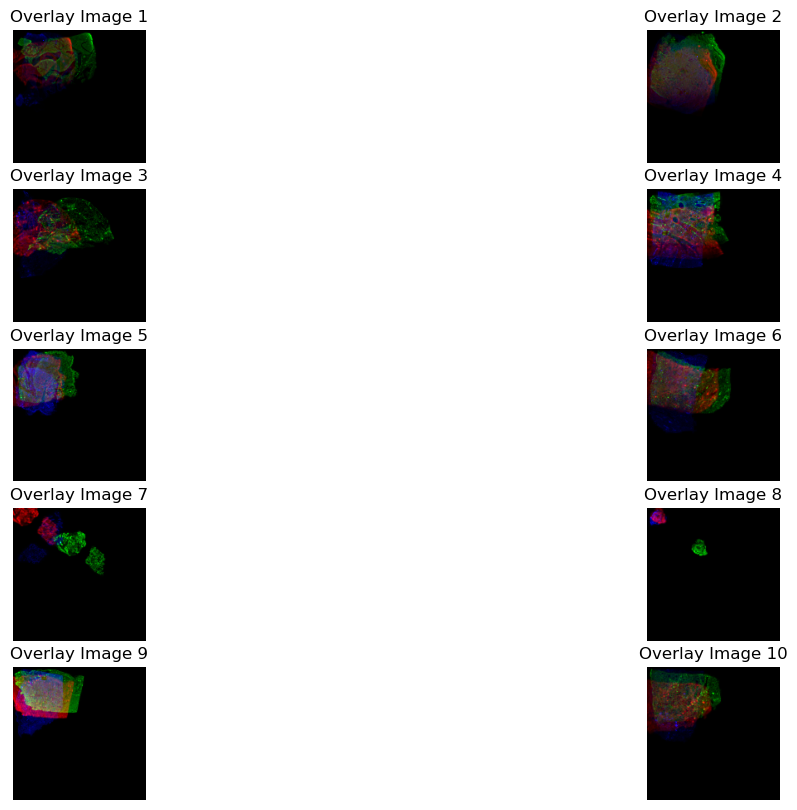

In [150]:
# Overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images[i]

    # Get the registered image
    registered_image = registered_images[reg_sampleid]

    # Normalize the images to the range [0, 1]
    registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
    axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
    color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')


### Metrics

In [152]:
#Compute mutual information, cross correlation, mse between the fixed regression and moving axis images 

def compute_metrics(fixed_image, moving_image):

    # Compute Mutual Information
    mutual_info = ants.image_mutual_information(fixed_image, moving_image)

    # Compute Cross Correlation
    cross_corr = ants.math.image_similarity(fixed_image, moving_image,'Correlation')

    # Compute Mean Squared Error
    mse = ants.math.image_similarity(fixed_image, moving_image,'MeanSquares')

    #Binarize the images
    fixed_image_bin = (fixed_image.numpy()> 0.5).astype(int)
    moving_image_bin =  (moving_image.numpy() > 0.5).astype(int)
    # Compute Jaccard Index
    jaccard_index = jaccard_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')
    
    #Compute the Dice coefficient
    f1 = f1_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')

    # Get image from array
    fixed_image = sitk.GetImageFromArray(fixed_image.numpy())
    moving_image = sitk.GetImageFromArray(moving_image.numpy())

    #Compute the Hausdorff distance
    hausdoroff_distance = sitk.HausdorffDistanceImageFilter()
    hausdoroff_distance.Execute(fixed_image, moving_image)
    hausdoroff_distance_value = hausdoroff_distance.GetHausdorffDistance()

    return mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value


In [164]:
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)



metrics_df.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\1465461372.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.065516,-0.103818,2.724935,0.767091,0.855049,44.407207
1,sampleid_710_image,sampleid_107_image,-0.249988,-0.352582,1.053541,0.809653,0.890759,17.464249
2,sampleid_712_image,sampleid_535_image,-0.041597,-0.027687,1.870518,0.685895,0.791194,53.000000
3,sampleid_713_image,sampleid_112_image,-0.199832,-0.310681,0.612326,0.786195,0.873698,29.000000
4,sampleid_714_image,sampleid_114_image,-0.184843,-0.363995,0.680353,0.868651,0.924843,19.235384
5,sampleid_715_image,sampleid_118_image,-0.134400,-0.302965,1.213255,0.746274,0.845162,40.718546
6,sampleid_678_image,sampleid_536_image,-0.006380,-0.004347,1.222197,0.864629,0.909408,61.220911
7,sampleid_679_image,sampleid_537_image,-0.000142,-0.000095,0.413955,0.968924,0.979349,62.008064
8,sampleid_716_image,sampleid_125_image,-0.145574,-0.371388,0.683017,0.828826,0.897641,36.400549
9,sampleid_717_image,sampleid_129_image,-0.196346,-0.297805,0.642421,0.844202,0.910658,25.000000


In [165]:
# Create a dataframe to store the metrics between the registered images and the regression images

metrics_df_registered = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image,registered_image)

    # Append the metrics to the DataFrame
    metrics_df_registered = pd.concat([metrics_df_registered, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\4149995457.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered = pd.concat([metrics_df_registered, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.124782,-0.202025,2.385341,0.742374,0.798400,23.000000
1,sampleid_710_image,sampleid_107_image,-0.241118,-0.377597,1.735052,0.613285,0.688556,17.804494
2,sampleid_712_image,sampleid_535_image,-0.162790,-0.316638,1.406335,0.717117,0.777403,17.000000
3,sampleid_713_image,sampleid_112_image,-0.198366,-0.358865,0.708117,0.657617,0.727078,28.442925
4,sampleid_714_image,sampleid_114_image,-0.125928,-0.296840,0.905707,0.755554,0.809195,25.179357
5,sampleid_715_image,sampleid_118_image,-0.150802,-0.241903,1.689495,0.657047,0.726589,28.160256
6,sampleid_678_image,sampleid_536_image,-0.007154,-0.001921,0.767560,0.914487,0.935184,52.839379
7,sampleid_679_image,sampleid_537_image,-0.001659,-0.001251,0.380212,0.975465,0.981735,77.820306
8,sampleid_716_image,sampleid_125_image,-0.128071,-0.331465,0.947065,0.757796,0.811036,33.015148
9,sampleid_717_image,sampleid_129_image,-0.198757,-0.424568,0.848083,0.710781,0.772106,17.088007


In [166]:
# Compute the difference between the metrics of the registered images and the regression images

metrics_diff = metrics_df_registered.copy()
metrics_diff['mutual_info'] = metrics_df_registered['mutual_info'] - metrics_df['mutual_info']
metrics_diff['cross_corr'] = metrics_df_registered['cross_corr'] - metrics_df['cross_corr']
metrics_diff['mse'] = metrics_df_registered['mse'] - metrics_df['mse']
metrics_diff['jaccard_index'] = metrics_df_registered['jaccard_index'] - metrics_df['jaccard_index']
metrics_diff['f1_score'] = metrics_df_registered['f1_score'] - metrics_df['f1_score']
metrics_diff['hausdorff_distance'] = metrics_df_registered['hausdorff_distance'] - metrics_df['hausdorff_distance']
metrics_diff.head(10)

,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.059266,-0.098207,-0.339593,-0.024717,-0.056649,-21.407207
1,sampleid_710_image,sampleid_107_image,0.008870,-0.025016,0.681511,-0.196369,-0.202203,0.340245
2,sampleid_712_image,sampleid_535_image,-0.121193,-0.288951,-0.464183,0.031222,-0.013791,-36.000000
3,sampleid_713_image,sampleid_112_image,0.001466,-0.048184,0.095791,-0.128578,-0.146620,-0.557075
4,sampleid_714_image,sampleid_114_image,0.058915,0.067155,0.225354,-0.113097,-0.115648,5.943973
5,sampleid_715_image,sampleid_118_image,-0.016401,0.061061,0.476240,-0.089227,-0.118572,-12.558290
6,sampleid_678_image,sampleid_536_image,-0.000774,0.002427,-0.454638,0.049859,0.025776,-8.381532
7,sampleid_679_image,sampleid_537_image,-0.001516,-0.001156,-0.033742,0.006541,0.002386,15.812242
8,sampleid_716_image,sampleid_125_image,0.017503,0.039924,0.264048,-0.071029,-0.086605,-3.385401
9,sampleid_717_image,sampleid_129_image,-0.002411,-0.126763,0.205662,-0.133421,-0.138552,-7.911993


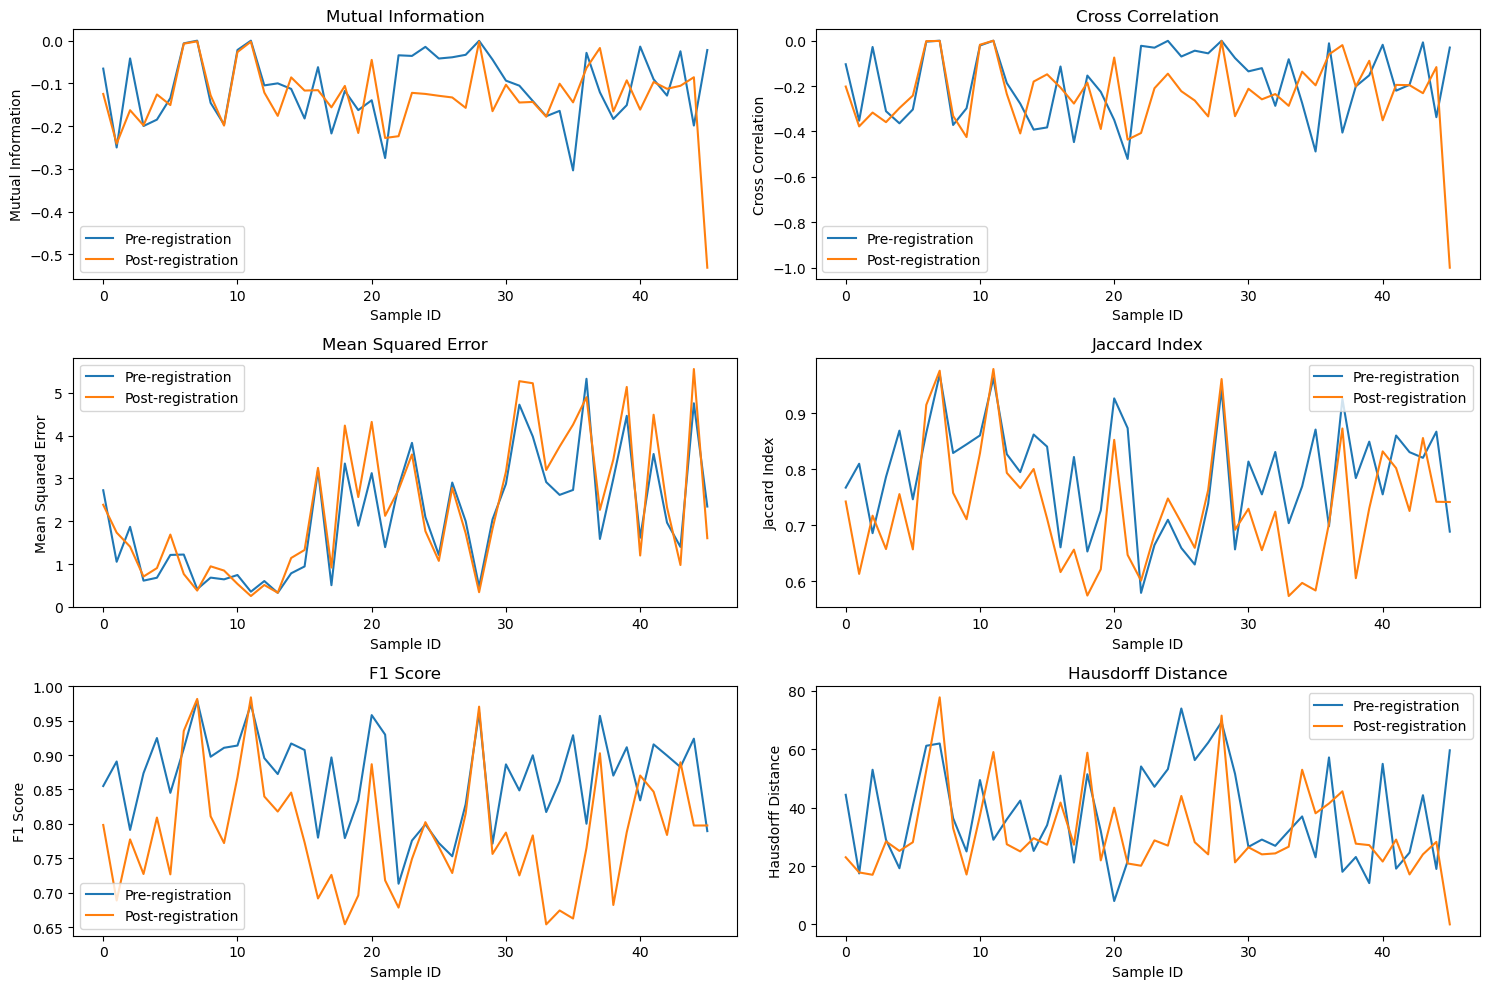

In [168]:
#Create a separate graph for each metric. Each graph should have 2 lines pre and post registration

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend()

axs[1].plot(metrics_df['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a separate graph for each metric. Each graph should have 2 bars, one for pre registration and one for post registration
# Set the figure size
plt.figure(figsize=(15, 10))
# Set the bar width
bar_width = 0.35
# Set the bar positions
bar_positions = np.arange(len(metrics_df_registered))
# Set the bar colors
bar_colors = ['#1f77b4', '#ff7f0e']
# Set the bar labels
bar_labels = ['Pre Registration', 'Post Registration']
# Create the bars for each metric
plt.bar(bar_positions, metrics_df_registered['cross_corr'], width=bar_width, color=bar_colors[0], label='Pre Registration')
plt.bar(bar_positions + bar_width, metrics_df['cross_corr'], width=bar_width, color=bar_colors[1], label='Post Registration')


In [172]:
 #Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and tbet panels

# Create a DataFrame to store the merged images
merged_df = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])

# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axi image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices[reg_sampleid]

    # Append the metrics to the DataFrame
    merged_df = pd.concat([merged_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix.parameters],
        'final_image_fixed_parameters': [transformation_matrix.fixed_parameters]
    })], ignore_index=True)

merged_df.head(10)

,reg_sampleid,axis_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_101_image,"[0.9999983906745911, -0.0017819120548665524, 0...","[41.98567581176758, 35.215389251708984]"
1,sampleid_710_image,sampleid_107_image,"[0.9861530065536499, -0.1658378392457962, 0.16...","[52.78548049926758, 42.120697021484375]"
2,sampleid_712_image,sampleid_535_image,"[0.9998102784156799, 0.01947912946343422, -0.0...","[50.77205276489258, 28.47519302368164]"
3,sampleid_713_image,sampleid_112_image,"[0.9998770952224731, 0.01567806303501129, -0.0...","[44.546478271484375, 39.62575912475586]"
4,sampleid_714_image,sampleid_114_image,"[0.999777615070343, 0.021087579429149628, -0.0...","[41.447025299072266, 30.321826934814453]"
5,sampleid_715_image,sampleid_118_image,"[0.9999647736549377, -0.008390155620872974, 0....","[45.331546783447266, 36.37406921386719]"
6,sampleid_678_image,sampleid_536_image,"[0.9999457597732544, -0.010415257886052132, 0....","[36.75742721557617, 39.46842575073242]"
7,sampleid_679_image,sampleid_537_image,"[1.0, 0.00018776457000058144, -0.0001877645700...","[11.912997245788574, 10.761759757995605]"
8,sampleid_716_image,sampleid_125_image,"[0.999995768070221, 0.0029187726322561502, -0....","[37.17987823486328, 31.23196792602539]"
9,sampleid_717_image,sampleid_129_image,"[0.9999510049819946, 0.009896975941956043, -0....","[43.60976791381836, 32.858036041259766]"


In [173]:
# Save the merged DataFrame to a CSV file
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_9.csv', index=False)

## Regression to Axis Rigid Regression (Scale 7)

In [179]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]


In [180]:
# Convert all images to numpy arrays
cropped_images_arrays_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_arrays_2[sampleid] = cropped_image.compute()

In [181]:
#Convert all images to ants images
cropped_images_ants_2 = {}
for sampleid, cropped_image in cropped_images_arrays_2.items():
    cropped_images_ants_2[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_2

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_image': AN

### Pad images

In [182]:
# Pad the images
padded_images_2 = pad_images_to_same_size(cropped_images_ants_2)

# Convert the padded images to ANTs images
padded_images_ants_2 = {}
for sampleid, padded_image in padded_images_2.items():
    padded_images_ants_2[sampleid] = ants.from_numpy(padded_image)

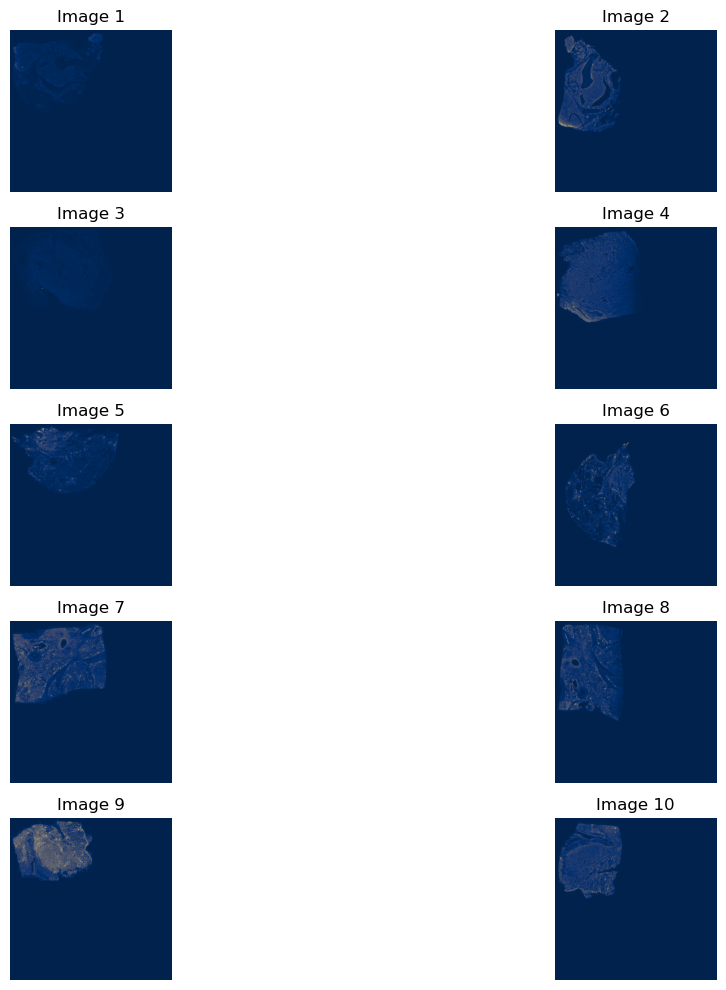

In [189]:


# Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_2.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

### Scale Images

In [190]:
def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale

def scale_transform(transform_path, scaling_factors):
    """
    Scale a 2D affine transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 2 values for 2D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Ensure the transform is 2D
        if transform.dimension != 2:
            raise ValueError("This function only supports 2D transformations.")
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 2
        elif len(scaling_factors) != 2:
            raise ValueError("Scaling factors must be a scalar or a list of 2 values for 2D transformations.")
        
        # Scale only the translation components (last two parameters for tx, ty in 2D affine)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 6:  # Ensure there are enough parameters for a 2D affine transform
            scaled_parameters[4:6] *= scaling_factors  # Scale translation components (tx, ty)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension (2D)
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")

In [82]:
#Compute the scaling factor between an image from scale 9 and scale 7

scaling_factor_1 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)

In [191]:
#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices[reg_sampleid]

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat', scaling_factor_1)

    # Store the scaled transformation matrix
    transformation_matrices[reg_sampleid] = scaled_transform_path

### ANTS Rigid transform

In [195]:
#Perform the registration using the scaled transformation matrix

# Create a dictionary to store the registered images
registered_images_scaled = {}

# Loop through each image and perform the registration

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Perform registration using the scaled transformation matrix
    registered_image_scaled = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Rigid', aff_metric='MeanSquares', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images_scaled[reg_sampleid] = registered_image_scaled['warpedmovout']

    #Apply the transformation to the moving image
    transformed_image_scaled = ants.apply_transforms(fixed=reg_image, moving=axis_image, transformlist=registered_image_scaled['fwdtransforms'])

antsRegistration -d 2 -r [0000029B2144BBA8,0000029B21449408,1] -m MeanSquares[0000029B2144BBA8,0000029B21449408,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,0000029B236CA9E8,0000029B20FA7D08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B2144BBA8,0000029B21449408,1] -m MeanSquares[0000029B2144BBA8,0000029B21449408,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000029B1901FAA8,0000029B236CA9E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B21449408,0000029B236CA9E8,1] -m MeanSquares[0000029B21449408,0000029B236CA9E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users

In [221]:
# Read the transformation matrices using ants.read_transform
transformation_matrices_scaled = {}
for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix_scaled = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')

    # Store the transformation matrix
    transformation_matrices_scaled[reg_sampleid] = transformation_matrix_scaled

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled = {}
for sampleid, matrix in transformation_matrices_scaled.items():
    transformation_parameters_scaled[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

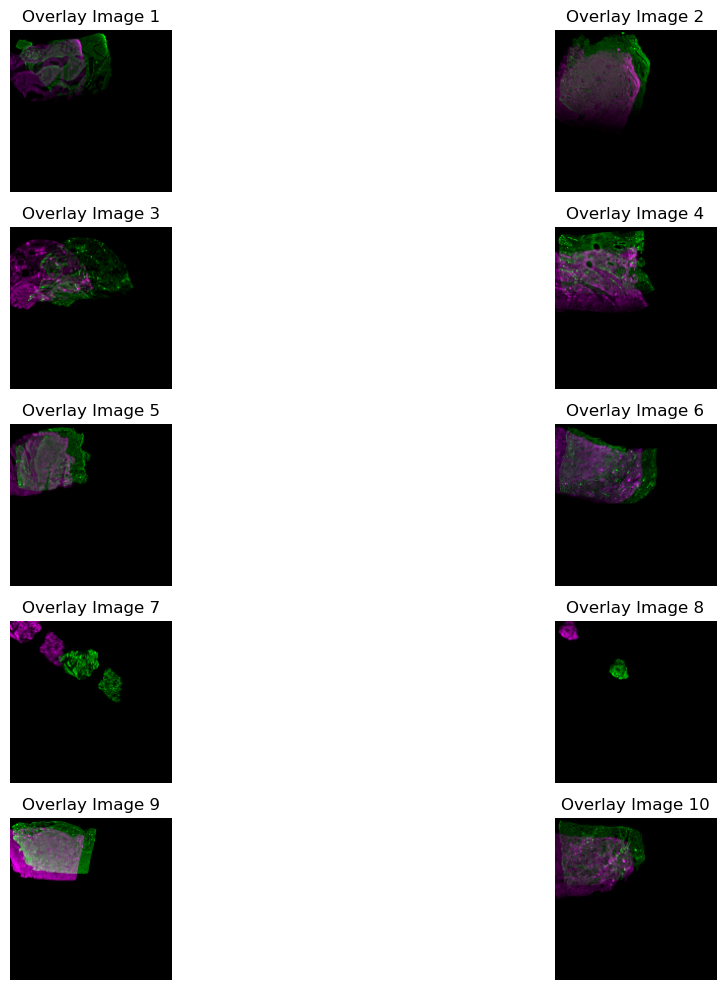

In [215]:
#Overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the registered image
    registered_image_scaled = registered_images_scaled[reg_sampleid]

    # Normalize the images to the range [0, 1]
    registered_image_scaled = (registered_image_scaled - registered_image_scaled.min()) / (registered_image_scaled.max() - registered_image_scaled.min())
    axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image_scaled.shape[0], registered_image_scaled.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image_scaled.numpy()  # Red channel (registered image)
    color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [217]:
#Create a DataFrame to store the metrics
metrics_df_scaled = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_scaled = pd.concat([metrics_df_scaled, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)
metrics_df_scaled.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\3061505388.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_scaled = pd.concat([metrics_df_scaled, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.105392,-0.221378,2.641432,0.816615,0.889867,25.495098
1,sampleid_710_image,sampleid_107_image,-0.276294,-0.372239,1.197993,0.811203,0.891365,19.000000
2,sampleid_712_image,sampleid_535_image,-0.055323,-0.078420,2.144532,0.728114,0.824803,39.012818
3,sampleid_713_image,sampleid_112_image,-0.156232,-0.234105,0.704837,0.771489,0.862081,18.973666
4,sampleid_714_image,sampleid_114_image,-0.202913,-0.470609,0.593871,0.891848,0.939450,15.297059
5,sampleid_715_image,sampleid_118_image,-0.263153,-0.446292,1.051402,0.877399,0.932403,14.000000
6,sampleid_678_image,sampleid_536_image,-0.002495,-0.001219,1.952372,0.864245,0.908719,66.887966
7,sampleid_679_image,sampleid_537_image,-0.000135,-0.000094,0.762714,0.965083,0.976430,63.411355
8,sampleid_716_image,sampleid_125_image,-0.219436,-0.395598,0.707727,0.876272,0.929353,13.892444
9,sampleid_717_image,sampleid_129_image,-0.172584,-0.377944,0.648279,0.841966,0.908610,16.401219


In [218]:
# Create a dataframe to store the metrics between the registered images and the regression images

metrics_df_registered_scaled = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image_scaled)

    # Append the metrics to the DataFrame
    metrics_df_registered_scaled = pd.concat([metrics_df_registered_scaled, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_scaled.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\1623013334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_scaled = pd.concat([metrics_df_registered_scaled, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.121423,-0.199478,2.397468,0.743185,0.799220,23.000000
1,sampleid_710_image,sampleid_107_image,-0.239565,-0.375094,1.738013,0.613411,0.688756,17.804494
2,sampleid_712_image,sampleid_535_image,-0.163198,-0.315630,1.408481,0.716724,0.777225,17.000000
3,sampleid_713_image,sampleid_112_image,-0.196215,-0.356333,0.710135,0.657939,0.727504,28.442925
4,sampleid_714_image,sampleid_114_image,-0.124905,-0.296344,0.906996,0.755760,0.809515,25.179357
5,sampleid_715_image,sampleid_118_image,-0.148619,-0.239897,1.696435,0.657749,0.727341,28.160256
6,sampleid_678_image,sampleid_536_image,-0.007605,-0.001914,0.772301,0.913889,0.934759,52.839379
7,sampleid_679_image,sampleid_537_image,-0.001654,-0.001240,0.381332,0.975233,0.981598,77.820306
8,sampleid_716_image,sampleid_125_image,-0.127108,-0.330266,0.948537,0.757968,0.811298,33.015148
9,sampleid_717_image,sampleid_129_image,-0.197210,-0.422593,0.849224,0.711048,0.772481,17.088007


In [219]:
# Compute the difference between the metrics of the registered images and the regression images
metrics_diff_scaled = metrics_df_registered_scaled.copy()
metrics_diff_scaled['mutual_info'] = metrics_df_registered_scaled['mutual_info'] - metrics_df_scaled['mutual_info']
metrics_diff_scaled['cross_corr'] = metrics_df_registered_scaled['cross_corr'] - metrics_df_scaled['cross_corr']
metrics_diff_scaled['mse'] = metrics_df_registered_scaled['mse'] - metrics_df_scaled['mse']
metrics_diff_scaled['jaccard_index'] = metrics_df_registered_scaled['jaccard_index'] - metrics_df_scaled['jaccard_index']
metrics_diff_scaled['f1_score'] = metrics_df_registered_scaled['f1_score'] - metrics_df_scaled['f1_score']
metrics_diff_scaled['hausdorff_distance'] = metrics_df_registered_scaled['hausdorff_distance'] - metrics_df_scaled['hausdorff_distance']
metrics_diff_scaled.head(10)

,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.016031,0.021900,-0.243964,-0.073431,-0.090646,-2.495098
1,sampleid_710_image,sampleid_107_image,0.036729,-0.002855,0.540021,-0.197793,-0.202609,-1.195506
2,sampleid_712_image,sampleid_535_image,-0.107874,-0.237210,-0.736051,-0.011390,-0.047579,-22.012818
3,sampleid_713_image,sampleid_112_image,-0.039982,-0.122228,0.005298,-0.113549,-0.134576,9.469259
4,sampleid_714_image,sampleid_114_image,0.078008,0.174265,0.313125,-0.136088,-0.129935,9.882298
5,sampleid_715_image,sampleid_118_image,0.114534,0.206394,0.645032,-0.219649,-0.205061,14.160256
6,sampleid_678_image,sampleid_536_image,-0.005111,-0.000695,-1.180070,0.049645,0.026040,-14.048587
7,sampleid_679_image,sampleid_537_image,-0.001519,-0.001146,-0.381382,0.010151,0.005169,14.408950
8,sampleid_716_image,sampleid_125_image,0.092328,0.065332,0.240810,-0.118304,-0.118055,19.122704
9,sampleid_717_image,sampleid_129_image,-0.024626,-0.044649,0.200944,-0.130918,-0.136130,0.686788


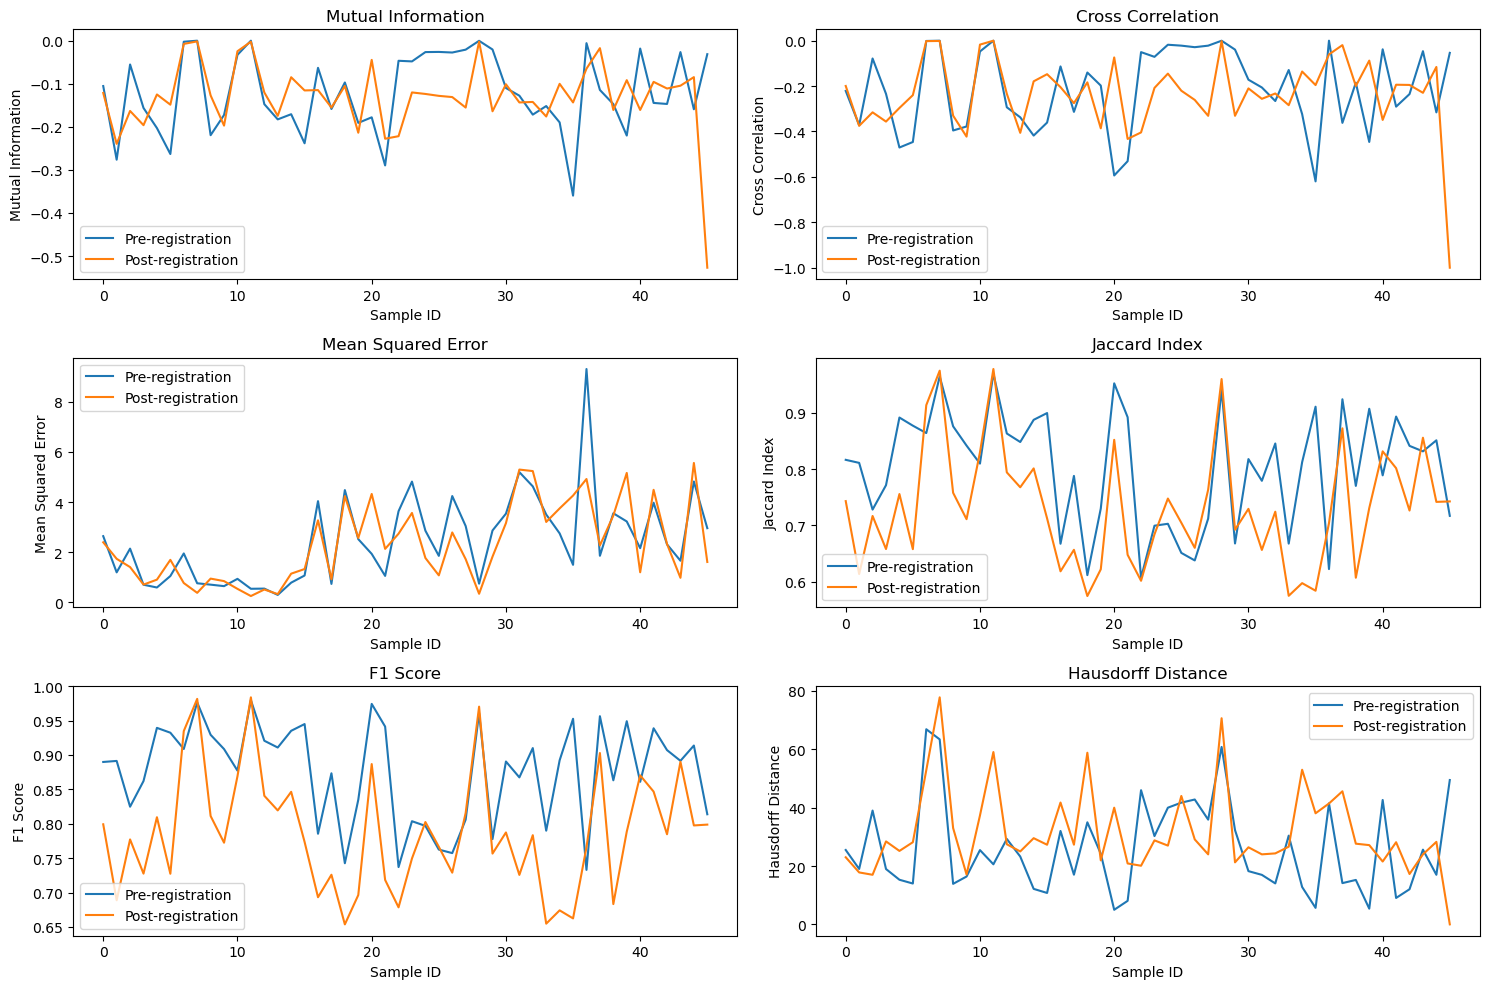

In [220]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df_scaled['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered_scaled['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend()
axs[1].plot(metrics_df_scaled['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered_scaled['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df_scaled['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered_scaled['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df_scaled['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered_scaled['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df_scaled['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered_scaled['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df_scaled['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered_scaled['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()



In [222]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and axis panels

# Create a DataFrame to store the merged images
merged_df_scaled = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    #Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    #Get the transformation matrix
    transformation_matrix_scaled = transformation_matrices_scaled[reg_sampleid]
    # Append the metrics to the DataFrame
    
    merged_df_scaled = pd.concat([merged_df_scaled, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix_scaled.parameters],
        'final_image_fixed_parameters': [transformation_matrix_scaled.fixed_parameters]
    })], ignore_index=True)
merged_df_scaled.head(10)

,reg_sampleid,axis_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_101_image,"[0.9999971389770508, -0.0024037142284214497, 0...","[35.78469467163086, 38.695011138916016]"
1,sampleid_710_image,sampleid_107_image,"[0.9859194755554199, -0.16722089052200317, 0.1...","[52.3446159362793, 43.38359832763672]"
2,sampleid_712_image,sampleid_535_image,"[0.9997776746749878, 0.021084709092974663, -0....","[49.75910186767578, 31.478918075561523]"
3,sampleid_713_image,sampleid_112_image,"[0.9998913407325745, 0.01474173367023468, -0.0...","[49.56389617919922, 41.547489166259766]"
4,sampleid_714_image,sampleid_114_image,"[0.9997866153717041, 0.020658383145928383, -0....","[39.213539123535156, 30.404258728027344]"
5,sampleid_715_image,sampleid_118_image,"[0.9999427795410156, -0.01069638691842556, 0.0...","[42.203426361083984, 39.67913818359375]"
6,sampleid_678_image,sampleid_536_image,"[0.9999397397041321, -0.01097603514790535, 0.0...","[16.229076385498047, 26.04356575012207]"
7,sampleid_679_image,sampleid_537_image,"[1.0, 4.0494007407687604e-05, -4.0494007407687...","[10.572916984558105, 13.35804271697998]"
8,sampleid_716_image,sampleid_125_image,"[0.9999938011169434, 0.0035140502732247114, -0...","[37.391685485839844, 33.165809631347656]"
9,sampleid_717_image,sampleid_129_image,"[0.9999427199363708, 0.010703346692025661, -0....","[44.4672737121582, 35.57392120361328]"


In [223]:
merged_df_scaled.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_7.csv', index=False)

## Affine Registration (Scale 5)

In [225]:
# Loop through each image in sp.images and crop it
cropped_images_3 = {}
for sampleid in sp.images:
    cropped_images_3[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=5)[0]


In [226]:
# Convert all images to numpy arrays
cropped_images_arrays_3 = {}
for sampleid, cropped_image in cropped_images_3.items():
    cropped_images_arrays_3[sampleid] = cropped_image.compute()

In [227]:
#Convert all images to ants images
cropped_images_ants_3 = {}
for sampleid, cropped_image in cropped_images_arrays_3.items():
    cropped_images_ants_3[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_3

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_

### Pad Images

In [230]:
# Pad the images
padded_images_3 = pad_images_to_same_size(cropped_images_ants_3)
# Convert the padded images to ANTs images
padded_images_ants_3 = {}
for sampleid, padded_image in padded_images_3.items():
    padded_images_ants_3[sampleid] = ants.from_numpy(padded_image)

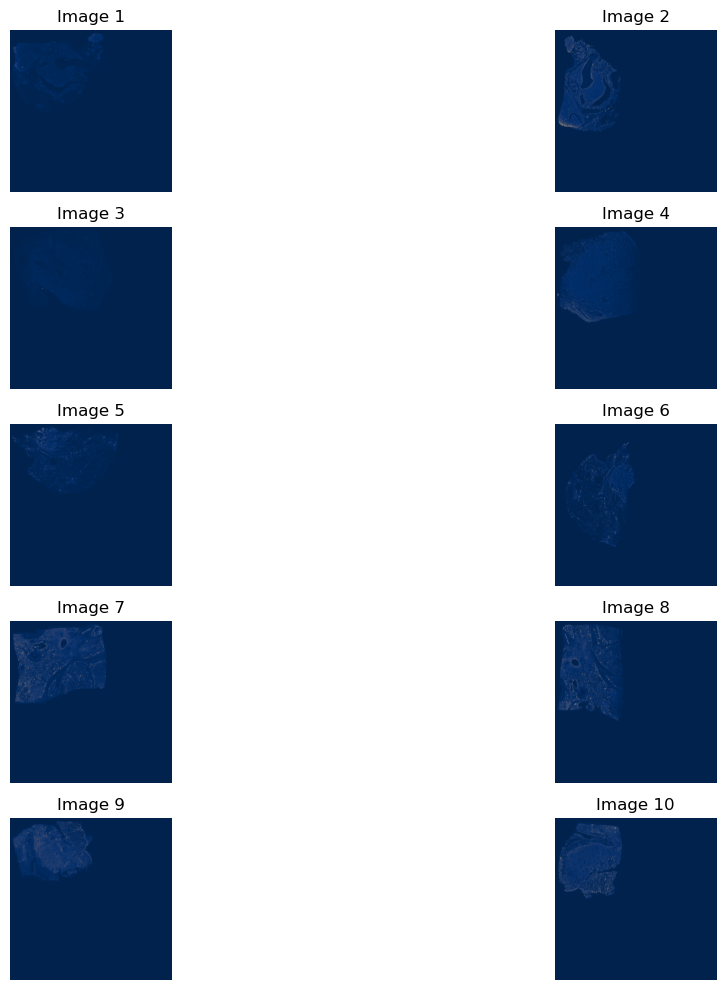

In [231]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_3.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [232]:
#Compute the scaling factor between an image from scale 7 and scale 5
scaling_factor_2 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_2 = float(scaling_factor_2)


In [248]:
#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_2)


### ANTS Affine transform

In [236]:
#Perform the registration using the scaled transformation matrix
# Create a dictionary to store the registered images
registered_images_scaled_2 = {}
# Loop through each image and perform the registration

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid,axis_image = axis_images[i]
    # Perform registration using the scaled transformation matrix
    registered_image_scaled_2 = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Affine', aff_metric='MeanSquares', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)
    # Store the registered image
    registered_images_scaled_2[reg_sampleid] = registered_image_scaled_2['warpedmovout']
    #Apply the transformation to the moving image
    transformed_image_scaled_2 = ants.apply_transforms(fixed=reg_image, moving=axis_image, transformlist=registered_image_scaled_2['fwdtransforms'])


antsRegistration -d 2 -r [0000029B1B92B868,0000029B1B92BE88,1] -m MeanSquares[0000029B1B92B868,0000029B1B92BE88,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,0000029B1EB14A88,0000029B1EB16EA8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1B92BE88,0000029B1B92BDE8,1] -m MeanSquares[0000029B1B92BE88,0000029B1B92BDE8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000029B1EB16EA8,0000029B1B92B868] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1B92BDE8,0000029B1B92B868,1] -m MeanSquares[0000029B1B92BDE8,0000029B1B92B868,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Us

In [249]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_2 = {}

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix_scaled_2 = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')
   
    # Store the transformation matrix
    transformation_matrices_scaled_2[reg_sampleid] = transformation_matrix_scaled_2
# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled_2 = {}
for sampleid, matrix in transformation_matrices_scaled_2.items():
    transformation_parameters_scaled_2[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

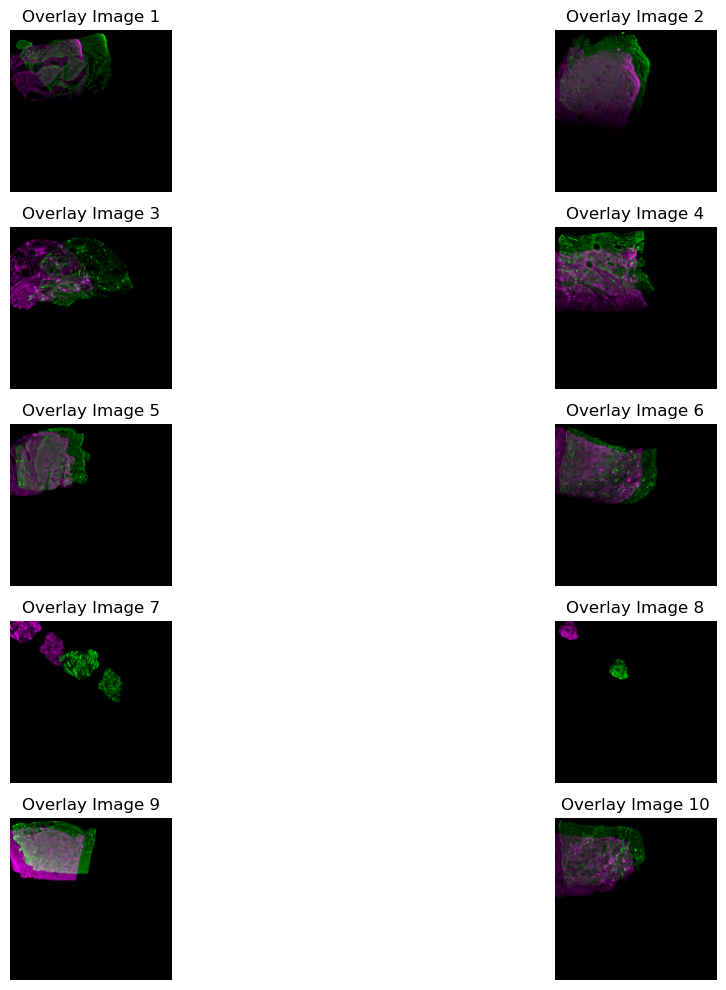

In [250]:
#Overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):

    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    # Get the registered image
    registered_image_scaled_2 = registered_images_scaled_2[reg_sampleid]

    # Normalize the images to the range [0, 1]

    registered_image_scaled_2 = (registered_image_scaled_2 - registered_image_scaled_2.min()) / (registered_image_scaled_2.max() - registered_image_scaled_2.min())
    axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())
    
    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image_scaled_2.shape[0], registered_image_scaled_2.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image_scaled_2.numpy()  # Red channel (registered image)
    color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()



### Metrics

In [251]:
#Create a DataFrame to store the metrics
metrics_df_scaled_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    tbet_sampleid, tbet_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_scaled_2 = pd.concat([metrics_df_scaled_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_scaled_2.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\1925415110.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_scaled_2 = pd.concat([metrics_df_scaled_2, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_196_image,-0.042116,-0.077261,2.448227,0.745055,0.801976,45.541190
1,sampleid_710_image,sampleid_196_image,-0.083511,-0.198548,1.755087,0.615069,0.691624,44.011362
2,sampleid_712_image,sampleid_196_image,-0.041515,-0.047440,1.459830,0.715974,0.777526,50.447993
3,sampleid_713_image,sampleid_196_image,-0.068138,-0.142486,0.727505,0.658897,0.729538,39.319207
4,sampleid_714_image,sampleid_196_image,-0.024972,-0.055950,0.938360,0.756240,0.810866,58.463664
5,sampleid_715_image,sampleid_196_image,-0.065877,-0.157728,1.708825,0.658026,0.728530,42.201896
6,sampleid_678_image,sampleid_196_image,-0.006279,-0.000624,0.781406,0.914125,0.935709,68.000000
7,sampleid_679_image,sampleid_196_image,-0.001889,-0.001385,0.387247,0.973844,0.980932,101.597244
8,sampleid_716_image,sampleid_196_image,-0.050555,-0.110470,0.972673,0.759857,0.814174,48.000000
9,sampleid_717_image,sampleid_196_image,-0.046432,-0.117135,0.880759,0.712160,0.774626,45.276926


In [252]:
# Create a dataframe to store the metrics between the registered images and the regression images
metrics_df_registered_scaled_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axi image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image_scaled_2)

    # Append the metrics to the DataFrame
    metrics_df_registered_scaled_2 = pd.concat([metrics_df_registered_scaled_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_scaled_2.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_52576\825189801.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_scaled_2 = pd.concat([metrics_df_registered_scaled_2, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.121537,-0.196276,2.427927,0.743082,0.799068,24.000000
1,sampleid_710_image,sampleid_107_image,-0.239591,-0.373489,1.743217,0.612675,0.688074,17.804494
2,sampleid_712_image,sampleid_535_image,-0.163837,-0.314259,1.416867,0.715137,0.775862,17.000000
3,sampleid_713_image,sampleid_112_image,-0.195692,-0.353528,0.712674,0.657115,0.726760,28.442925
4,sampleid_714_image,sampleid_114_image,-0.125308,-0.295530,0.908093,0.755285,0.809087,25.317978
5,sampleid_715_image,sampleid_118_image,-0.148439,-0.239256,1.706936,0.657115,0.726760,28.160256
6,sampleid_678_image,sampleid_536_image,-0.006879,-0.001863,0.779955,0.913890,0.934721,54.120237
7,sampleid_679_image,sampleid_537_image,-0.001636,-0.001231,0.385818,0.975426,0.981734,77.820306
8,sampleid_716_image,sampleid_125_image,-0.127803,-0.330739,0.950990,0.757560,0.810925,34.000000
9,sampleid_717_image,sampleid_129_image,-0.196261,-0.419423,0.853586,0.710323,0.771836,17.000000


In [253]:
#Compute the difference between the metrics of the registered images and the regression images
metrics_diff_scaled_2 = metrics_df_registered_scaled_2.copy()
metrics_diff_scaled_2['mutual_info'] = metrics_df_registered_scaled_2['mutual_info'] - metrics_df_scaled_2['mutual_info']
metrics_diff_scaled_2['cross_corr'] = metrics_df_registered_scaled_2['cross_corr'] - metrics_df_scaled_2['cross_corr']
metrics_diff_scaled_2['mse'] = metrics_df_registered_scaled_2['mse'] - metrics_df_scaled_2['mse']
metrics_diff_scaled_2['jaccard_index'] = metrics_df_registered_scaled_2['jaccard_index'] - metrics_df_scaled_2['jaccard_index']
metrics_diff_scaled_2['f1_score'] = metrics_df_registered_scaled_2['f1_score'] - metrics_df_scaled_2['f1_score']
metrics_diff_scaled_2['hausdorff_distance'] = metrics_df_registered_scaled_2['hausdorff_distance'] - metrics_df_scaled_2['hausdorff_distance']
metrics_diff_scaled_2.head(10)

,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.079421,-0.119014,-0.020301,-0.001973,-0.002907,-21.541190
1,sampleid_710_image,sampleid_107_image,-0.156080,-0.174941,-0.011870,-0.002394,-0.003550,-26.206868
2,sampleid_712_image,sampleid_535_image,-0.122322,-0.266819,-0.042962,-0.000837,-0.001664,-33.447993
3,sampleid_713_image,sampleid_112_image,-0.127554,-0.211042,-0.014832,-0.001782,-0.002778,-10.876281
4,sampleid_714_image,sampleid_114_image,-0.100336,-0.239580,-0.030267,-0.000956,-0.001780,-33.145686
5,sampleid_715_image,sampleid_118_image,-0.082562,-0.081528,-0.001889,-0.000912,-0.001770,-14.041640
6,sampleid_678_image,sampleid_536_image,-0.000600,-0.001239,-0.001451,-0.000235,-0.000988,-13.879763
7,sampleid_679_image,sampleid_537_image,0.000254,0.000154,-0.001429,0.001583,0.000802,-23.776938
8,sampleid_716_image,sampleid_125_image,-0.077248,-0.220268,-0.021683,-0.002298,-0.003250,-14.000000
9,sampleid_717_image,sampleid_129_image,-0.149828,-0.302288,-0.027173,-0.001837,-0.002790,-28.276926


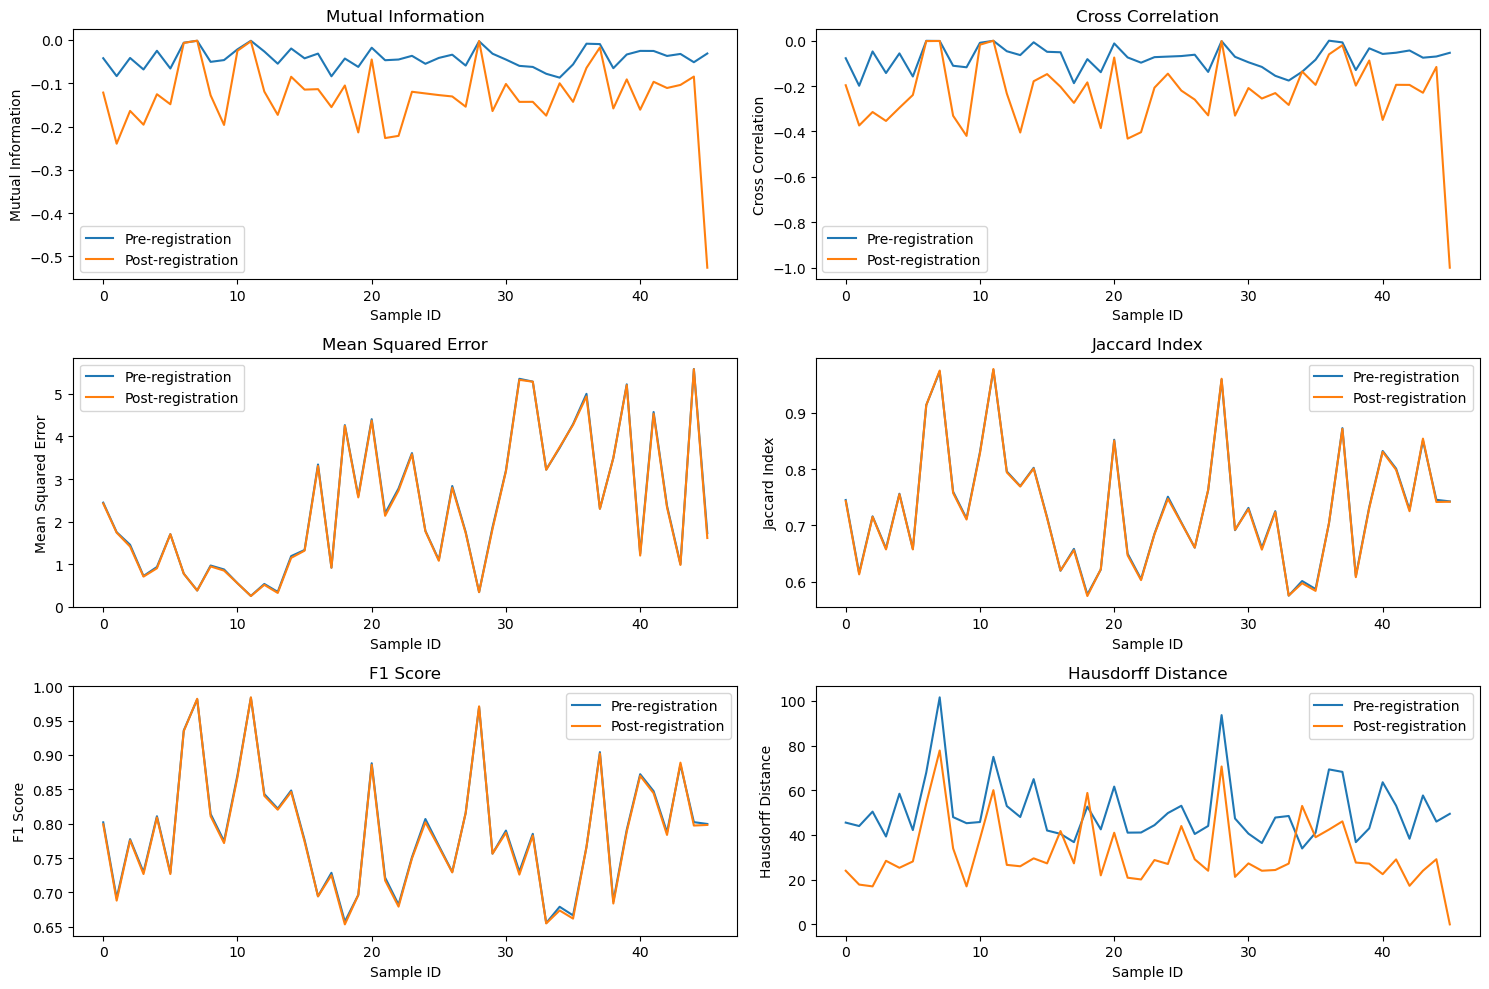

In [254]:
#Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df_scaled_2['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered_scaled_2['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend() 
axs[1].plot(metrics_df_scaled_2['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered_scaled_2['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df_scaled_2['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered_scaled_2['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df_scaled_2['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered_scaled_2['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df_scaled_2['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered_scaled_2['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df_scaled_2['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered_scaled_2['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()
plt.show()



In [255]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and axis panels

# Create a DataFrame to store the merged images

merged_df_scaled_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])

# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):


    #Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
  
  
    # Append the metrics to the DataFrame
    
    merged_df_scaled_2 = pd.concat([merged_df_scaled_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix_scaled_2.parameters],
        'final_image_fixed_parameters': [transformation_matrix_scaled_2.fixed_parameters]
    })], ignore_index=True)


merged_df_scaled_2.head(10)

,reg_sampleid,axis_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_101_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
1,sampleid_710_image,sampleid_107_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
2,sampleid_712_image,sampleid_535_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
3,sampleid_713_image,sampleid_112_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
4,sampleid_714_image,sampleid_114_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
5,sampleid_715_image,sampleid_118_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
6,sampleid_678_image,sampleid_536_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
7,sampleid_679_image,sampleid_537_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
8,sampleid_716_image,sampleid_125_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"
9,sampleid_717_image,sampleid_129_image,"[0.9982908368110657, -0.002434781286865473, 0....","[52.613319396972656, 31.90351104736328]"


In [256]:
merged_df_scaled_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_5.csv', index=False)

## Affine Registration (Scale 3)

In [257]:
# Loop through each image in sp.images and crop it
cropped_images_4 = {}
for sampleid in sp.images:
    cropped_images_4[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=3)[0]

In [260]:
#Convert all images to numpy arrays
cropped_images_arrays_4 = {}
for sampleid, cropped_image in cropped_images_4.items():
    cropped_images_arrays_4[sampleid] = cropped_image.compute()
    

In [261]:
#Convert all images to ants images
cropped_images_ants_4 = {}
for sampleid, cropped_image in cropped_images_arrays_4.items():
    cropped_images_ants_4[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_4


{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 6144)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 6144)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_

### Pad the images

In [262]:
# Pad the images
padded_images_4 = pad_images_to_same_size(cropped_images_ants_4)
# Convert the padded images to ANTs images
padded_images_ants_4 = {}
for sampleid, padded_image in padded_images_4.items():
    padded_images_ants_4[sampleid] = ants.from_numpy(padded_image)
    

MemoryError: Unable to allocate 400. MiB for an array with shape (10240, 10240) and data type float32

In [ ]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_4.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Compute the scaling factor between an image from scale 5 and scale 3
scaling_factor_3 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_3 = float(scaling_factor_3)


In [ ]:

#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_3)
    

### ANTS Affine transform

In [ ]:
#Perform the registration using the scaled transformation matrix
# Create a dictionary to store the registered images
registered_images_scaled_2 = {}
# Loop through each image and perform the registration

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    # Perform registration using the scaled transformation matrix
    registered_image_scaled_2 = ants.registration(fixed=reg_image, moving=tbet_image, type_of_transform='Affine', aff_metric='MeanSquares', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)
    # Store the registered image
    registered_images_scaled_2[reg_sampleid] = registered_image_scaled_2['warpedmovout']
    #Apply the transformation to the moving image
    transformed_image_scaled_2 = ants.apply_transforms(fixed=reg_image, moving=tbet_image, transformlist=registered_image_scaled_2['fwdtransforms'])


In [ ]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_3 = {}

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix_scaled_3 = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')
   
    # Store the transformation matrix
    transformation_matrices_scaled_3[reg_sampleid] = transformation_matrix_scaled_3

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled_3 = {}
for sampleid, matrix in transformation_matrices_scaled_3.items():
    transformation_parameters_scaled_3[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }


In [ ]:
#overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):

    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    # Get the registered image
    registered_image_scaled_2 = registered_images_scaled_2[reg_sampleid]

    # Normalize the images to the range [0, 1]

    registered_image_scaled_2 = (registered_image_scaled_2 - registered_image_scaled_2.min()) / (registered_image_scaled_2.max() - registered_image_scaled_2.min())
    axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())
    
    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image_scaled_2.shape[0], registered_image_scaled_2.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image_scaled_2.numpy()  # Red channel (registered image)
    color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Create a DataFrame to store the metrics
metrics_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_scaled_3 = pd.concat([metrics_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_scaled_3.head(10)



In [ ]:
# Create a dataframe to store the metrics between the registered images and the regression images
metrics_df_registered_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])

# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image_scaled_2)

    # Append the metrics to the DataFrame
    metrics_df_registered_scaled_3 = pd.concat([metrics_df_registered_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_scaled_3.head(10)

In [ ]:
#Compute the difference between the metrics of the registered images and the regression images
metrics_diff_scaled_3 = metrics_df_registered_scaled_3.copy()
metrics_diff_scaled_3['mutual_info'] = metrics_df_registered_scaled_3['mutual_info'] - metrics_df_scaled_3['mutual_info']
metrics_diff_scaled_3['cross_corr'] = metrics_df_registered_scaled_3['cross_corr'] - metrics_df_scaled_3['cross_corr']
metrics_diff_scaled_3['mse'] = metrics_df_registered_scaled_3['mse'] - metrics_df_scaled_3['mse']
metrics_diff_scaled_3['jaccard_index'] = metrics_df_registered_scaled_3['jaccard_index'] - metrics_df_scaled_3['jaccard_index']
metrics_diff_scaled_3['f1_score'] = metrics_df_registered_scaled_3['f1_score'] - metrics_df_scaled_3['f1_score']
metrics_diff_scaled_3['hausdorff_distance'] = metrics_df_registered_scaled_3['hausdorff_distance'] - metrics_df_scaled_3['hausdorff_distance']

In [ ]:
#create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df_scaled_3['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered_scaled_3['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend()
axs[1].plot(metrics_df_scaled_3['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered_scaled_3['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df_scaled_3['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered_scaled_3['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df_scaled_3['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered_scaled_3['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df_scaled_3['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered_scaled_3['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df_scaled_3['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered_scaled_3['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()
plt.show()







In [ ]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and axis panels
# Create a DataFrame to store the merged images
merged_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    #Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    #Get the transformation matrix
    transformation_matrix_scaled_3 = transformation_matrices_scaled_3[reg_sampleid]
    # Append the metrics to the DataFrame
    
    merged_df_scaled_3 = pd.concat([merged_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix_scaled_3.parameters],
        'final_image_fixed_parameters': [transformation_matrix_scaled_3.fixed_parameters]
    })], ignore_index=True)
merged_df_scaled_3.head(10)


In [ ]:
merged_df_scaled_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_3.csv', index=False)